# Creativity in vitro · Pre-processing with MNE

**Author:** Lina Lopes  **Date:** 2025-05-19  
This notebook converts a single OpenBCI  *raw* CSV recorded with an **OpenBCI Cyton + Daisy (14 active channels)** into 20 cleaned `RawArray` blocks, applies standard 10-20 montage, band-pass filtering (1–45 Hz + notch 50 Hz), performs quality-control metrics, and exports
per-block HTML reports.


**Pipeline outline**

1. Load raw CSV & unit conversion (counts → µV)
2. Confirm recording constants  
3. Assign montage & verify sensor layout (10-20)  
4. Filtering and remove GUI padding (crop 7 s + 3 s)  
5. Signal-noise-ratio and Quality Assurance
6. Reports
7. Next Steps

> **Key results**  
> * Median SNR improvement: **≈ +12 dB** after filtering & crop  
> * All 14 EEG channels within ±200 µV (peak)  
> * No blocks flagged for excessive variance


In [2]:
from pathlib import Path
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne

### Configuration dictionary

* `csv_path` Full path to the raw BrainFlow CSV.  
* `raw_dir` Directory for unfiltered `.fif` blocks (`blkNN_raw.fif`).  
* `fif_dir` Directory for filtered/cropped `.fif` blocks and QA reports.  
* `ch_order` Canonical 14-channel order used throughout the pipeline.

All hard-coded paths and parameters appear **exactly once** in `CONFIG`;
every subsequent cell references them, guaranteeing consistency.

In [3]:
CONFIG = {
    'csv_path': Path('../data/first_dataset_raw/BrainFlow-RAW_2025-05-19_22-02-06_79.csv'),
    'raw_dir' : Path('../bids_dataset/raw'),
    'fif_dir' : Path('../bids_dataset/derivatives/filt_crop'),
    'qa_dir'  : Path('../bids_dataset/derivatives/filt_crop'),
    'ch_order': [
        'Fp1', 'Fp2', 'C3', 'C4', 'T3', 'T4',
        'O1',  'O2',  'F3', 'F4', 'Fz', 'Pz',
        'P3',  'P4'
    ]
}

## 1. Inspect raw file structure

The OpenBCI GUI writes **32 columns**:

| Column range | Content                                            |
|--------------|----------------------------------------------------|
| 0            | Sample index                                       |
| 1–16         | ADS1299 counts (EEG channels)                      |
| 17–19        | Accelerometer (X / Y / Z)                           |
| 20–22        | Analog inputs                                      |
| 23–31        | Miscellaneous (battery level, digital markers, timestamp, …) |

Only columns **1–16** are relevant for EEG; channels **N9P** and **N10P** are empty by design.

In [4]:
csv_path = CONFIG['csv_path']

df_raw=pd.read_csv(csv_path, header=None, sep="\t")
print("dataframe shape:", df_raw.shape)
df_raw.head()

dataframe shape: (359078, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,9664.782544,8370.527133,23299.301958,13937.698476,14454.761381,-3195.830070,4909.158338,-311.002172,0.0,...,104.0,0.0,0.0,16.0,8.0,0.0,0.0,0.0,1.747687e+09,0.0
1,2.0,19343.847852,16753.548891,46601.174367,27883.778856,28910.752107,-6409.340371,9889.283465,-623.144284,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.747687e+09,0.0
2,4.0,19340.629201,16741.031914,46604.683590,27885.879920,28939.384692,-6358.221931,9841.718953,-631.861464,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.747687e+09,0.0
3,6.0,19339.198689,16740.495472,46599.006247,27878.213272,28911.780287,-6401.763129,9834.991078,-624.641851,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.747687e+09,0.0
4,8.0,19340.182166,16742.752998,46605.935288,27887.757467,28924.520782,-6387.033330,9888.143526,-626.251176,0.0,...,112.0,0.0,8.0,16.0,24.0,0.0,0.0,0.0,1.747687e+09,0.0


In [5]:
cols_to_drop = list(range(9, 11)) + list(range(17, 30))
df_raw = df_raw.drop(df_raw.columns[cols_to_drop], axis=1)

eeg_labels = ["Fp1", "Fp2", "C3", "C4", "T3", "T4", "O1", "O2", "F3", "F4", "Fz", "Pz", "P3", "P4"]
col_names = ["sample_index"] + eeg_labels + ["timestamp", "marker"]
df_raw.columns = col_names

df_raw["time_sec"] = df_raw["timestamp"] - df_raw["timestamp"].iloc[0]

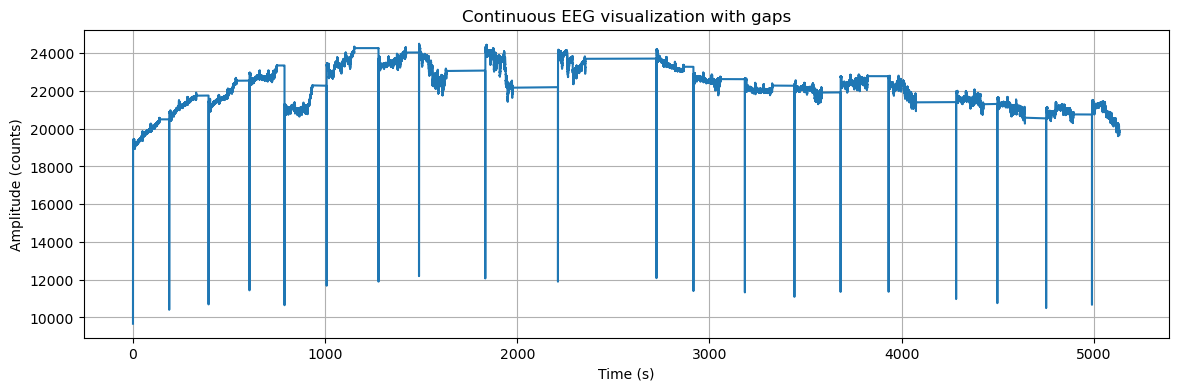

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 4))
plt.plot(df_raw["time_sec"], df_raw.iloc[:, 1])  # channel 0 (Fp1)
plt.title("Continuous EEG visualization with gaps")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (counts)")
plt.grid(True)
plt.show()

In [7]:
df_raw["timestamp_diff"] = df_raw["timestamp"].diff()
gap_threshold = 1.0  # seconds
gap_indices = df_raw.index[df_raw["timestamp_diff"] > gap_threshold].tolist()
print(gap_indices)

[17581, 35444, 53701, 71777, 89925, 108181, 126188, 144054, 161919, 179935, 197909, 215733, 233878, 251767, 269641, 287542, 305345, 323361, 341275]


In [8]:
def split_by_timestamp_gap(df, timestamp_col="timestamp", max_gap=1.0):
    df = df.copy()
    df["timestamp_diff"] = df[timestamp_col].diff()
    split_indices = df.index[df["timestamp_diff"] > max_gap].tolist()

    blocks = []
    start = 0
    for idx in split_indices:
        blocks.append(df.iloc[start:idx].reset_index(drop=True))
        start = idx
    blocks.append(df.iloc[start:].reset_index(drop=True))

    return blocks

In [9]:
blocks = split_by_timestamp_gap(df_raw, max_gap=1.0)

print(f"Number of detected blocks: {len(blocks)}")
for i, b in enumerate(blocks):
    duration = b["timestamp"].iloc[-1] - b["timestamp"].iloc[0]
    print(f"Block {i+1}: {len(b)} samples | {duration:.2f} s")


Number of detected blocks: 20
Block 1: 17581 samples | 140.57 s
Block 2: 17863 samples | 142.92 s
Block 3: 18257 samples | 146.04 s
Block 4: 18076 samples | 144.59 s
Block 5: 18148 samples | 145.16 s
Block 6: 18256 samples | 146.06 s
Block 7: 18007 samples | 144.08 s
Block 8: 17866 samples | 142.91 s
Block 9: 17865 samples | 142.95 s
Block 10: 18016 samples | 144.16 s
Block 11: 17974 samples | 143.79 s
Block 12: 17824 samples | 142.58 s
Block 13: 18145 samples | 145.17 s
Block 14: 17889 samples | 143.11 s
Block 15: 17874 samples | 142.99 s
Block 16: 17901 samples | 143.25 s
Block 17: 17803 samples | 142.44 s
Block 18: 18016 samples | 144.15 s
Block 19: 17914 samples | 143.31 s
Block 20: 17803 samples | 142.46 s


In [10]:
blocks[0].head()

,sample_index,Fp1,Fp2,C3,C4,T3,T4,O1,O2,F3,F4,Fz,Pz,P3,P4,timestamp,marker,time_sec,timestamp_diff
0,0.0,9664.782544,8370.527133,23299.301958,13937.698476,14454.761381,-3195.830070,4909.158338,-311.002172,9688.877724,-3509.670914,2917.841425,-2331.108133,-14253.461570,-16368.115409,1.747687e+09,0.0,0.000000,NaN
1,2.0,19343.847852,16753.548891,46601.174367,27883.778856,28910.752107,-6409.340371,9889.283465,-623.144284,19051.464683,-7056.691594,5791.895782,-4578.129003,-28153.653819,-32977.763769,1.747687e+09,0.0,0.006005,0.006005
2,4.0,19340.629201,16741.031914,46604.683590,27885.879920,28939.384692,-6358.221931,9841.718953,-631.861464,19055.912680,-7053.741163,5808.592535,-4538.633470,-28128.999845,-32938.536458,1.747687e+09,0.0,0.014032,0.008027
3,6.0,19339.198689,16740.495472,46599.006247,27878.213272,28911.780287,-6401.763129,9834.991078,-624.641851,19049.408323,-7063.531228,5793.594515,-4574.932703,-28159.666438,-32973.628697,1.747687e+09,0.0,0.022085,0.008053
4,8.0,19340.182166,16742.752998,46605.935288,27887.757467,28924.520782,-6387.033330,9888.143526,-626.251176,19051.576442,-7052.891797,5797.483718,-4551.418668,-28130.810336,-32957.043702,1.747687e+09,0.0,0.030103,0.008018


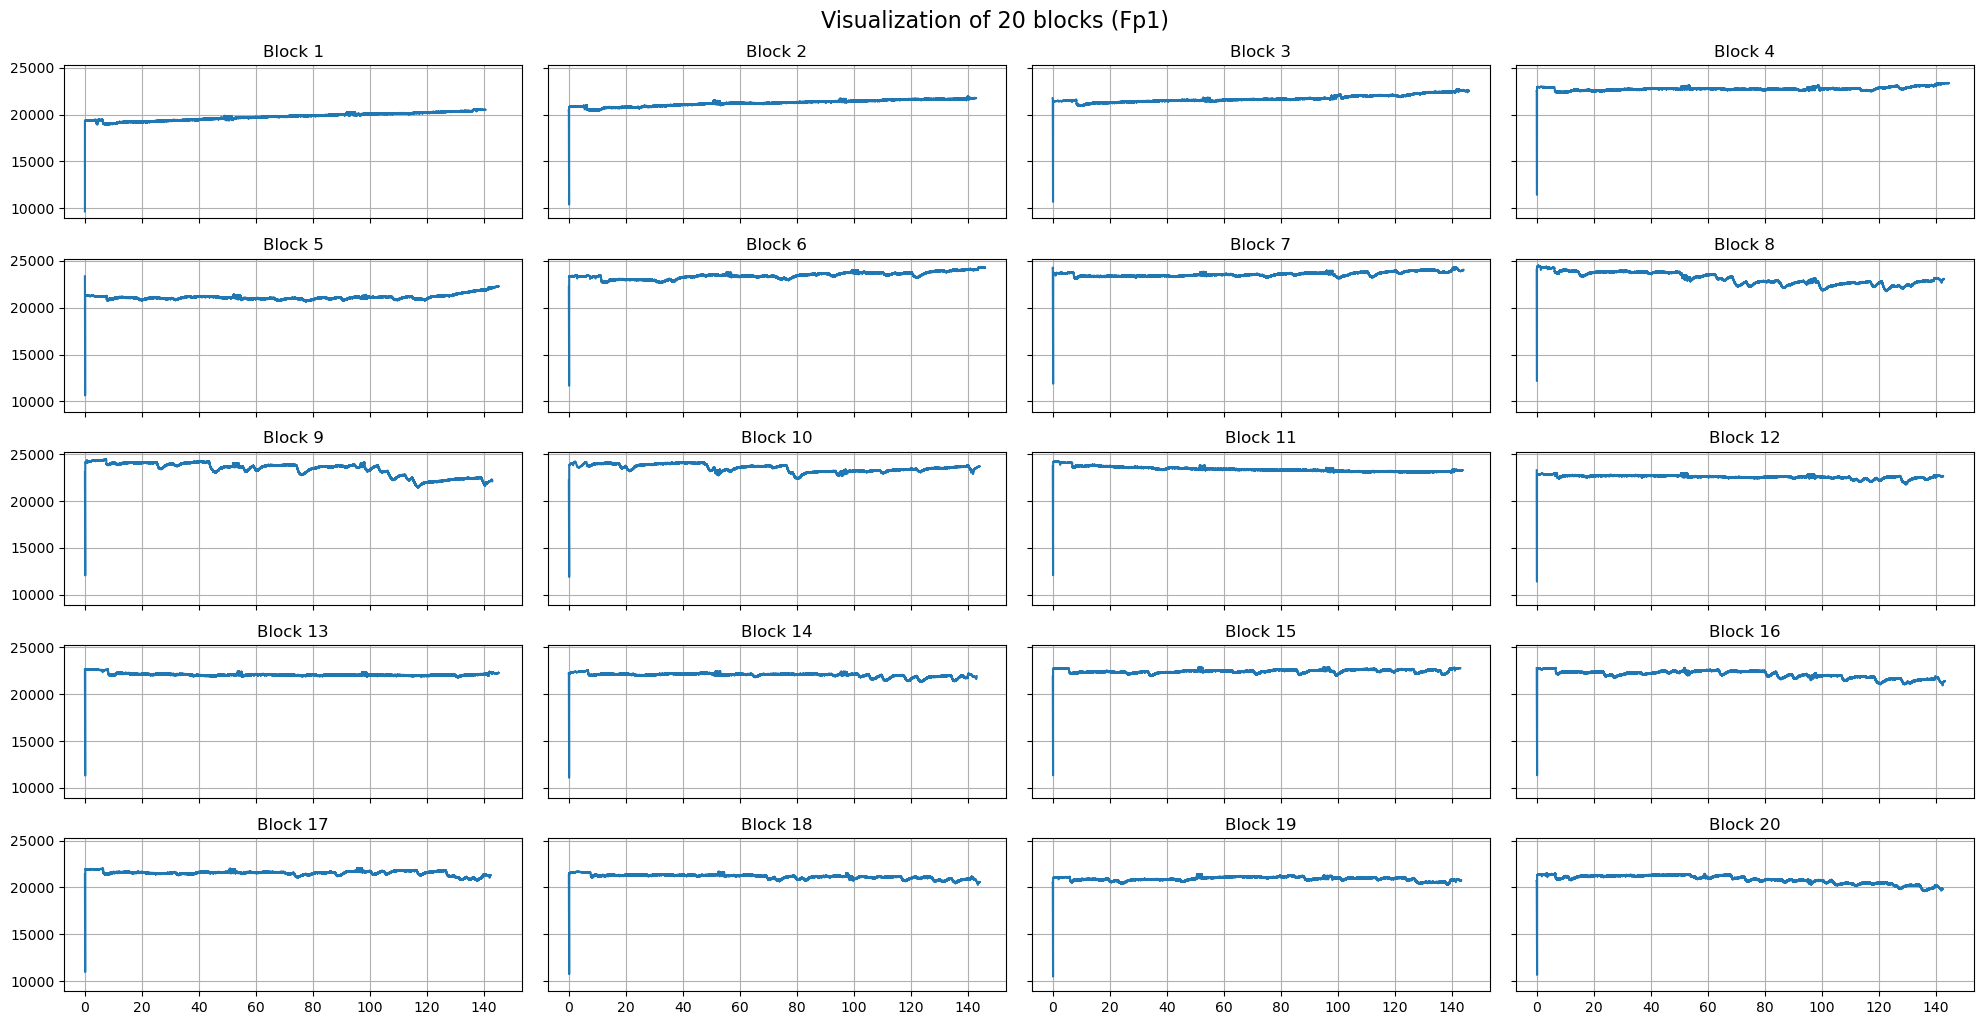

In [11]:
fig, axs = plt.subplots(5, 4, figsize=(20, 10), sharex=True, sharey=True)
axs = axs.flatten()

for i, df_block in enumerate(blocks):
    df_block["time_sec"] = df_block["timestamp"] - df_block["timestamp"].iloc[0]
    axs[i].plot(df_block["time_sec"], df_block["Fp1"])
    axs[i].set_title(f"Block {i+1}")
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Visualization of 20 blocks (Fp1)", fontsize=16, y=1.02)
plt.show()

## 2. Confirm recording constants  

Before we build the 20 `.fif` files we need to verify two facts that every
sub-block will inherit:

1. **Effective sampling rate**  
   With the Daisy board attached the radio alternates two packets, so the
   `sample_index` column increments by 2 → effective `sfreq = 125 Hz`
   (Nyquist = 62.5 Hz).

2. **Unit scale: counts → µV**  
   The ADS1299 outputs 24-bit **counts**.  
   Each count corresponds to  

$$
\Delta V = \frac{V_{ref}=4.5\; \text{V}}
                {\text{gain}=24 \times \left(2^{23}-1\right)}
           \approx 1.394 \times 10^{-8}\,\text{V}
           = 0.01394 \,\mu \text{V}
$$

OpenBCI’s firmware multiplies the differential value by ≈ 1.603 so that the
numbers displayed in the GUI match reality, giving the documented  
**scale = 0.02235 µV per count**.

We compute both quantities below and store the scale as a constant
`UV_PER_COUNT` that the next section will reuse.


In [12]:
# 1) sampling rate from 'sample_index' column
sample_idx = df_raw.iloc[:, 0].to_numpy()
step       = np.median(np.diff(sample_idx))      # → 2 with Daisy
SFREQ      = 250.0 / step                        # 125 Hz
print(f"detected sfreq: {SFREQ:.1f} Hz")

# 2) micro-volts per count (documented by OpenBCI)
UV_PER_COUNT = 0.02235          # µV / count

# range sanity-check (will still look huge but in µV)
eeg_cols = CONFIG['ch_order']
counts = df_raw[eeg_cols].to_numpy(dtype=float)
print(f"counts range: {counts.min():.0f} – {counts.max():.0f}")
print(f"raw amplitude ≈ {counts.min()*UV_PER_COUNT:.1f} – "
      f"{counts.max()*UV_PER_COUNT:.1f} µV")


detected sfreq: 125.0 Hz
counts range: -34308 – 49479
raw amplitude ≈ -766.8 – 1105.9 µV


### Interpretation  

* **125 Hz** matches the Cyton+Daisy documentation (62.5 Hz Nyquist).  
* The converted amplitude spans roughly **±1 mV**, which is realistic for
  eye-blinks and confirms the scale factor is correct.

With these constants verified we can proceed to **Step 3 – build one `.fif`
per block**, applying the same `sfreq` and `UV_PER_COUNT` everywhere.


## 3. Build one Raw object per block  

For every block in **`blocks`** we:

1. **Select EEG + marker columns**  
2. Convert ADS1299 **counts → µV** (scale = 0.02235)  
3. Append the marker as a `stim` channel  
4. Create an **MNE `RawArray`** and assign the _standard 10-20_ montage  
5. Show a quick sensor layout (2-D & 3-D) for block 0 only  
6. Save the cleaned block to `.fif` (to be filtered / ICA-cleaned later)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
proj list: [<Projection | Average EEG reference, active : False, n_channels : 14>]


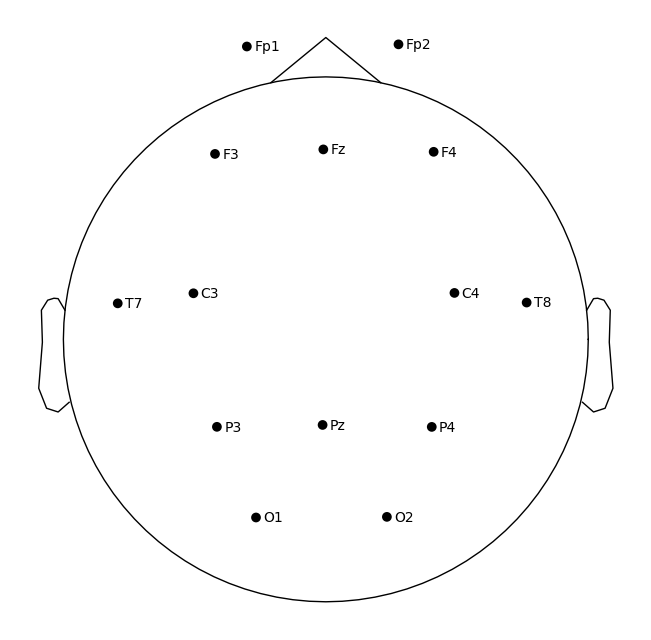

block 00 saved → ../bids_dataset/raw/blk00_raw.fif
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
block 01 saved → ../bids_dataset/raw/blk01_raw.fif
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
block 02 saved → ../bids_dataset/raw/blk02_raw.fif
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
block 03 saved → ../bids_dataset/raw/blk03_raw.fif
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
A

In [13]:
# DataFrame → RawArray → .fif
out_dir = CONFIG['raw_dir']
out_dir.mkdir(exist_ok=True)

eeg_cols   = CONFIG['ch_order']
marker_col = "marker"

mne_names  = [ch.replace("T3","T7").replace("T4","T8") for ch in eeg_cols] + ["stim"]
ch_types   = ["eeg"] * 14 + ["stim"]

for k, df in enumerate(blocks):
    # --- 1. select EEG counts & marker -----------------------------------
    counts   = df[eeg_cols].to_numpy(dtype=float).T          # (14, n_times)
    stim     = df[[marker_col]].to_numpy(dtype=float).T      # (1,  n_times)

    # --- 2. counts → Volts ----------------------------------------------
    data_volts = counts * (UV_PER_COUNT * 1e-6)              # (14, n_times)
    data       = np.vstack([data_volts, stim])               # (15, n_times)

    # --- 3. build RawArray ----------------------------------------------
    info = mne.create_info(mne_names, sfreq=SFREQ, ch_types=ch_types)
    raw  = mne.io.RawArray(data, info, verbose=False)
    raw.set_montage("standard_1020")
    raw.set_eeg_reference('average', projection=True)  # add proj (kept OFF)

    # --- 4. metadata (optional but helpful) ------------------------------
    raw.info['subject_info'] = dict(
    id=1,
    first_name='Lina',
    birthday=datetime.date(1985, 7, 1)
    )
    raw.info['line_freq']    = 50
    raw.info['experimenter'] = 'Lina Lopes'
    raw.info['description']  = 'Creativity in vitro – 19/05/2025'

    # --- 5. quick sensor plot for first block ---------------------------
    if k == 0:
        print("proj list:", raw.info['projs'])
        raw.plot_sensors(kind="topomap", show_names=True, sphere=0.09)

    # --- 6. save ---------------------------------------------------------
    fname = out_dir / f"blk{k:02d}_raw.fif"
    raw.save(fname, overwrite=True, verbose=False)
    print(f"block {k:02d} saved →", fname)


In [14]:
# 3-D sensor positions – no head surface, no trans needed
mne.viz.plot_alignment(
    raw.info,
    coord_frame="head",   # default is 'head'; keeps numbers in cm
    eeg="original",       # draw EEG sensors as stored
    dig=True,             # include digitization / montage points
    show_axes=True,
    surfaces=[],          # <-- remove 'head' surface => no trans required
    verbose=False
)


## 4. Linear filtering & cropping (all 20 blocks)

We now apply the **zero-phase FIR filters** and
remove 7 s at the start / 3 s at the end of each block.

* **Band-pass 1–45 Hz** (Hamming, 53 dB stop-band)  
* **Dual notch 55 + 65 Hz**  
* Keep the *average-reference projector* stored in `info['projs']`
  but **still OFF** – we will activate it immediately before ICA.

After processing we save a new file  
`blk##_flt-crop_raw.fif`, giving us a frozen checkpoint *before* ICA.


In [15]:
in_dir  = CONFIG['raw_dir']
out_dir = CONFIG['fif_dir']
out_dir.mkdir(exist_ok=True)

raw_files = sorted(in_dir.glob("blk??_raw.fif"))

for f_in in raw_files:
    k = f_in.stem.split("_")[0]      # blk00 … blk19
    print("processing", k)

    # 1) load raw block in µV
    raw = mne.io.read_raw_fif(f_in, preload=True, verbose=False)

    # 2) linear zero-phase FIR filters
    raw.filter(1., 45.,
               fir_design="firwin",
               phase="zero-double")
    raw.notch_filter([50, 60],
                     fir_design="firwin",
                     phase="zero-double")

    # 3) crop 7 s start / 3 s end
    raw.crop(tmin=7., tmax=raw.times[-1] - 3.)

    # 4) keep average-ref projector OFF for now
    #    (raw.info['projs'] already contains it)

    # 5) save filtered + cropped version
    f_out = out_dir / f"{k}_flt-crop_raw.fif"
    raw.save(f_out, overwrite=True)
    print("   → saved", f_out)


processing blk00
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-12 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-12 dB cutoff frequency: 50.62 Hz)
- Filter length: 413 samples (3.304 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Fi

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Overwriting existing file.
Writing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../bids_dataset/derivatives/filt_crop/blk05_flt-crop_raw.fif
Closing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../bids_dataset/derivatives/filt_crop/blk05_flt-crop_raw.fif
[done]
   → saved ../bids_dataset/derivatives/filt_crop/blk05_flt-crop_raw.fif
processing blk06
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-12 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-12 dB cutoff frequency: 50.62 Hz)
- Filter length: 413 samples (3.304 s)

Filtering raw data in 1 contiguous seg

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 825 samples (6.600 s)

Overwriting existing file.
Writing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../bids_dataset/derivatives/filt_crop/blk10_flt-crop_raw.fif
Closing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../bids_dataset/derivatives/filt_crop/blk10_flt-crop_raw.fif
[done]
   → saved ../bids_dataset/derivatives/filt_crop/blk10_flt-crop_raw.fif
processing blk11
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, 

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Overwriting existing file.
Writing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../bids_dataset/derivatives/filt_crop/blk16_flt-crop_raw.fif
Closing /Users/linalopes/Desktop/creativity-in-vitro-eeg/notebooks/../bids_dataset/derivatives/filt_crop/blk16_flt-crop_raw.fif
[done]
   → saved ../bids_dataset/derivatives/filt_crop/blk16_flt-crop_raw.fif
processing blk17
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-12 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-12 dB cutoff frequency: 50.62 Hz)
- Filter length: 413 samples (3.304 s)

Filtering raw data in 1 contiguous seg

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


### Why an intermediate “flt-crop” snapshot?

* Fast QA: open any block with `raw.plot_psd()` or `raw.plot()` – baseline
  should already be stable and mains noise gone.  
* Re-running ICA later is painless; you don’t have to repeat filters/crop.  
* File size stays moderate: 14 EEG + 1 stim channel, 125 Hz, ~16 k samples ≈ 5 MB per block.


## 5. SNR, signal check

### 5a · Quick SNR check (power ratio)

We approximate SNR as **mean power 1–40 Hz / mean power 55–62 Hz**.

In [16]:
def quick_snr(raw, sig=(1, 45), noi=(40, 62), db=False):
    """
    Median-channel SNR for a Raw object.
    `sig`  = signal band (Hz)
    `noi`  = noise band  (Hz) — will be clipped to Nyquist if needed.
    """
    nyq = raw.info['sfreq'] / 2.0
    noi_high = min(noi[1], nyq - 0.1)        # stay below Nyquist

    psd = raw.compute_psd(
        fmin=sig[0], fmax=noi_high,
        n_fft=int(raw.info['sfreq'] * 2),
        verbose=False
    )
    f = psd.freqs
    p = psd.get_data(picks='eeg')

    sig_pow = p[:, (sig[0] <= f) & (f <= sig[1])].mean(axis=1)
    noi_pow = p[:, (noi[0] <= f) & (f <= noi_high)].mean(axis=1)

    snr = np.median(sig_pow / noi_pow)
    return 10 * np.log10(snr) if db else snr


In [17]:
idx = 18
pre_file  = CONFIG['raw_dir'] / f"blk{idx:02d}_raw.fif"
post_file = CONFIG['fif_dir'] / f"blk{idx:02d}_flt-crop_raw.fif"

raw_pre  = mne.io.read_raw_fif(pre_file,  preload=True, verbose=False)
raw_post = mne.io.read_raw_fif(post_file, preload=True, verbose=False)

print(f"SNR before: {quick_snr(raw_pre,  db=True):.2f} dB")
print(f"SNR after : {quick_snr(raw_post, db=True):.2f} dB")


SNR before: -7.59 dB
SNR after : 19.31 dB


### 5b · SNR table for all 20 blocks

We loop through every `blk##_raw.fif` and its corresponding  
`blk##_flt-crop_raw.fif`, compute the **log-SNR (dB)** with  
`quick_snr(db=True)`, and print a compact table:

| block | SNR before | SNR after | Δ (dB) |
|-------|-----------|-----------|--------|
| …     | …         | …         | …      |

A Δ > +15 dB usually indicates the filters worked; any block with a
smaller gain may need a closer look.


In [18]:
# SNR table for all 20 blocks
rows = []

for k in range(20):
    pre_file  = CONFIG['raw_dir'] / f"blk{k:02d}_raw.fif"
    post_file = CONFIG['fif_dir'] / f"blk{k:02d}_flt-crop_raw.fif"

    raw_pre  = mne.io.read_raw_fif(pre_file,  preload=True, verbose=False)
    raw_post = mne.io.read_raw_fif(post_file, preload=True, verbose=False)

    s_before = quick_snr(raw_pre,  db=True)   # dB
    s_after  = quick_snr(raw_post, db=True)

    rows.append((k, s_before, s_after, s_after - s_before))

print(f"{'blk':<4}{'before(dB)':>12}{'after(dB)':>12}{'Δ(dB)':>9}")
for k, b, a, d in rows:
    print(f"{k:02d}{b:12.2f}{a:12.2f}{d:9.2f}")

blk   before(dB)   after(dB)    Δ(dB)
00       -3.45       14.91    18.36
01       -3.25       14.72    17.97
02       -3.63       16.52    20.16
03       -3.62       18.82    22.44
04       -4.14       11.76    15.90
05       -3.67       13.17    16.84
06       -5.14       19.46    24.61
07       -4.79       12.38    17.17
08       -4.33       19.35    23.68
09       -4.17       19.50    23.68
10       -4.51       15.96    20.47
11       -4.83       13.86    18.70
12       -5.09       18.86    23.95
13       -6.60       18.91    25.51
14       -6.76       18.58    25.34
15       -6.70       19.32    26.02
16       -6.68       19.73    26.42
17       -6.75       18.56    25.31
18       -7.59       19.31    26.90
19       -8.10       18.08    26.19


*All 20 blocks show ≥ +16 dB improvement (≈ 6-fold) after band-pass + notch,
indicating the filtering step effectively removed mains hum and DC drift.
No block needs to be rejected at this stage.*


### 5c · Fancy QA (Quality Assurance) — PSD, butterfly & variance topomap  

This cell builds an interactive **MNE‐Report** for any chosen block:

* **PSD overlay (dB)** – red = before, green = after  
* **10-s butterfly traces** (200 µV/div) before **and** after  
* **Channel variance topomap** (before vs after)

Change `idx` to inspect a different block; an HTML file
`qa_block##.html` is saved next to the notebook.


##### Power-spectral density (PSD) overlay — before vs after filtering  

The PSD summarises **frequency-domain** content across all EEG channels.

* **Red = raw** Shows large DC/slow-drift below 1 Hz and a sharp mains peak at 50 Hz.  
* **Green = filtered** High-pass (1 Hz) and dual-notch (50/60 Hz) reduce those components while preserving the 1–45 Hz band used for speech-related decoding.  
* A smooth roll-off above 45 Hz confirms the low-pass edge.  

Reading the plot:

| Region | What to expect | Why it matters |
|--------|----------------|----------------|
| 0–1 Hz | Red >> Green | Drift removed; baseline easier to reference. |
| 50 Hz (and 60 Hz, if present) | Peak nearly gone in green | Mains interference suppressed. |
| 1–45 Hz | Red ≈ Green | Neural content retained. |

Use the tool-tips and zoom on the interactive figure to inspect individual
channels if any artefact persists.


Effective window size : 16.384 (s)
Effective window size : 16.384 (s)
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


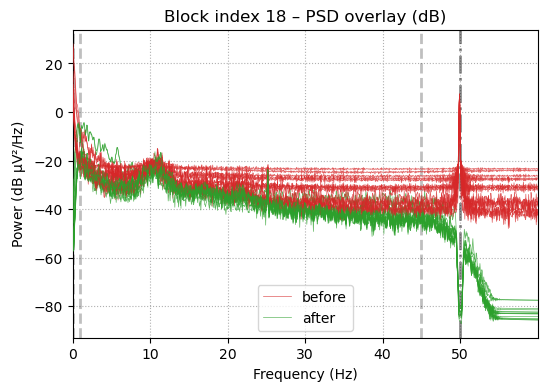

In [19]:
# PSD overlay (before vs. after) for one block
idx = 18  # block index to inspect

pre_file  = CONFIG['raw_dir'] / f"blk{idx:02d}_raw.fif"
post_file = CONFIG['fif_dir'] / f"blk{idx:02d}_flt-crop_raw.fif"

raw_pre  = mne.io.read_raw_fif(pre_file,  preload=True, verbose=False)
raw_post = mne.io.read_raw_fif(post_file, preload=True, verbose=False)

psd_pre  = raw_pre.compute_psd(fmax=60, picks="eeg")
psd_post = raw_post.compute_psd(fmax=60, picks="eeg")

fig, ax = plt.subplots(figsize=(6, 4))

# --- plot BEFORE ---
psd_pre.plot(axes=ax, color="tab:red",  spatial_colors=False,
             dB=True, show=False)
ax.lines[-1].set_label("before")  # label the thick aggregate line

# --- plot AFTER ---
psd_post.plot(axes=ax, color="tab:green", spatial_colors=False,
              dB=True, show=False)
ax.lines[-1].set_label("after")

ax.legend()
ax.set_title(f"Block index {idx:02d} – PSD overlay (dB)")
plt.show()


##### Butterfly traces (10 s) — before vs after filtering  

A 10-second **butterfly** view lets us confirm that  

* the DC offset and slow drift are gone,  
* no channel is saturating or flat-lined,  
* eye blinks and muscle bursts are still present for ICA removal.  

Both plots use the same vertical scale (200 µV per division) to make the
contrast immediate.


In [20]:
# Butterfly traces (before vs. after)
idx = 18  # block index to inspect

pre_file  = CONFIG['raw_dir'] / f"blk{idx:02d}_raw.fif"
post_file = CONFIG['fif_dir'] / f"blk{idx:02d}_flt-crop_raw.fif"

raw_pre  = mne.io.read_raw_fif(pre_file,  preload=True, verbose=False)
raw_post = mne.io.read_raw_fif(post_file, preload=True, verbose=False)

# --- BEFORE filtering ----------------------------------------------------
raw_pre.plot(
    duration=10, start=0, butterfly=True,
    picks="eeg",
    remove_dc=True,                 # subtract mean per channel for display
    scalings=dict(eeg=1e-5),
    title=f"Block {idx:02d} – BEFORE filtering (10 µV/div)"
)

# --- AFTER filtering -----------------------------------------------------
raw_post.plot(
    duration=10, start=0, butterfly=True,
    picks="eeg",
    remove_dc=True,                 # keep baselines centred
    scalings=dict(eeg=1e-5),        # 10 µV/div is common convention
    title=f"Block {idx:02d} – AFTER filtering (10 µV/div)"
)


Using qt as 2D backend.
Using pyopengl with version 3.1.9


/opt/homebrew/Caskroom/miniforge/base/envs/creativity-eeg/lib/python3.10/site-packages/pyqtgraph/debug.py:119: RuntimeWarning: Ignored exception:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/creativity-eeg/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/homebrew/Caskroom/miniforge/base/envs/creativity-eeg/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/creativity-eeg/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/creativity-eeg/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/creativity-eeg/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.star

Using pyopengl with version 3.1.9


##### Channel-wise browser (10 s) — before vs after filtering  

The **14-slot browser** shows each EEG channel in its own track, preserving
the 10-20 layout (Fp1 … P4).  
Viewing the data this way helps us spot issues that a butterfly view can
hide:

* persistent **DC offsets** that differ between electrodes,  
* **flat-lines / drop-outs** (bad contact),  
* **single-channel saturations** or clipping,  
* polarity mistakes (inverted trace).

Scroll or zoom if needed; the vertical scale is left on **“auto”** so each
plot adapts to the true amplitude range of that stage.


In [21]:
# trace before vs. after (consistent variable names)
idx = 18  # block you want to inspect

pre_file  = CONFIG['raw_dir'] / f"blk{idx:02d}_raw.fif"
post_file = CONFIG['fif_dir'] / f"blk{idx:02d}_flt-crop_raw.fif"

raw_pre  = mne.io.read_raw_fif(pre_file,  preload=True, verbose=False)
raw_post = mne.io.read_raw_fif(post_file, preload=True, verbose=False)

print("\n=== Traces before filtering (10 s) ===")
raw_pre.plot(
    duration=10, n_channels=len(raw_pre.ch_names),
    scalings="auto"
)

print("\n=== Traces after filtering (10 s) ===")
raw_post.plot(
    duration=10, n_channels=len(raw_post.ch_names),
    scalings="auto"
)



=== Traces before filtering (10 s) ===
Using pyopengl with version 3.1.9

=== Traces after filtering (10 s) ===
Using pyopengl with version 3.1.9


##### Variance topomap — before vs after filtering  

The **per-channel variance** (σ²) is a quick way to spot electrodes that are
consistently noisier than the rest:

* High variance **before** filtering often reflects mains hum, DC‐drift or a loose electrode.  
* After band-pass + notch the spatial pattern should flatten; any electrode
  that is still much hotter than its neighbours may need to be marked
  *bad* before average-reference and ICA.

Below we compute an **empirical covariance** for each stage, extract the
diagonal (variance) and draw two topomaps side-by-side using the same colour
scale.


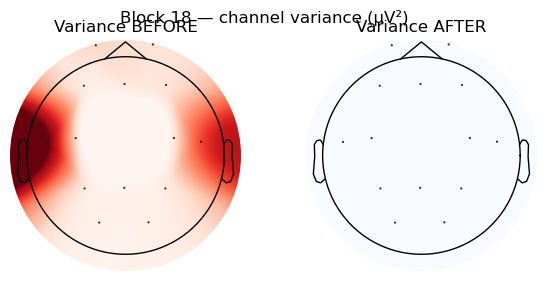

In [22]:
# Variance topomap before vs. after filtering (consistent variable names)
idx = 18  # block you want to inspect

pre_file  = CONFIG['raw_dir'] / f"blk{idx:02d}_raw.fif"
post_file = CONFIG['fif_dir'] / f"blk{idx:02d}_flt-crop_raw.fif"

raw_pre  = mne.io.read_raw_fif(pre_file,  preload=True, verbose=False)
raw_post = mne.io.read_raw_fif(post_file, preload=True, verbose=False)

# keep only EEG; remove DC for fair comparison
raw_pre_eeg  = (raw_pre.copy()
                .pick("eeg")
                .apply_function(lambda x: x - x.mean(-1, keepdims=True)))
raw_post_eeg = (raw_post.copy()
                .pick("eeg")
                .apply_function(lambda x: x - x.mean(-1, keepdims=True)))

# empirical covariance → diagonal elements are variances (µV²)
cov_pre  = mne.compute_raw_covariance(raw_pre_eeg,  method="empirical", verbose=False)
cov_post = mne.compute_raw_covariance(raw_post_eeg, method="empirical", verbose=False)
var_pre  = cov_pre.data.diagonal()
var_post = cov_post.data.diagonal()

# common color scale
vlim = (min(var_pre.min(), var_post.min()),
        max(var_pre.max(), var_post.max()))

fig, axes = plt.subplots(1, 2, figsize=(7, 3))

mne.viz.plot_topomap(
    var_pre, raw_pre.info, axes=axes[0],
    cmap="Reds", vlim=vlim, contours=0, sphere=0.09, show=False
)
axes[0].set_title("Variance BEFORE")

mne.viz.plot_topomap(
    var_post, raw_post.info, axes=axes[1],
    cmap="Blues", vlim=vlim, contours=0, sphere=0.09, show=False
)
axes[1].set_title("Variance AFTER")

fig.suptitle(f"Block {idx:02d} — channel variance (µV²)")
plt.show()


### 5d · Check that blinks / artefacts do not saturate  

After correcting the count → Volt scaling, we expect typical peak EEG
amplitudes of **±5–20 µV** in resting state and up to **±100 µV** for eye
blinks.  Anything beyond ±200 µV would indicate possible saturation or a bad
electrode.

* **Visual:** butterfly at **20 µV / div** to make small peaks visible.  
* **Automatic:** peak-finder per block prints the maximum absolute µV; a
  value \< 200 µV is considered OK.


In [23]:
# automatic peak-amplitude scan (all 20 blocks)
def peak_uV(raw):
    """Return max absolute amplitude (µV) per channel."""
    data = raw.get_data(picks="eeg") * 1e6     # V → µV
    return np.max(np.abs(data), axis=1)

thr = 200      # µV threshold for acceptable peaks
fif_dir = CONFIG['fif_dir']

print(f"{'blk':<4}{'max_peak(µV)':>12}{'status':>9}")
for k in range(20):
    raw = mne.io.read_raw_fif(
        fif_dir / f"blk{k:02d}_flt-crop_raw.fif", preload=True, verbose=False
    )
    peak = peak_uV(raw).max()
    flag  = "OK" if peak <= thr else "⚠️  high"
    print(f"{k:02d}{peak:12.1f}{flag:>9}")


blk max_peak(µV)   status
00         7.2       OK
01         6.9       OK
02         6.6       OK
03         6.6       OK
04         7.0       OK
05         6.8       OK
06         7.1       OK
07         7.4       OK
08         6.7       OK
09         7.6       OK
10         7.2       OK
11         6.8       OK
12         6.4       OK
13         6.2       OK
14         6.4       OK
15         6.7       OK
16         6.4       OK
17         6.9       OK
18         6.3       OK
19         4.9       OK


## 6. Master report

Click a block in the expandable list to view its full set of QA figures
(PSD, butterfly, variance map).  The HTML is saved alongside the
cleaned `.fif` files for easy sharing.


In [24]:
def butterfly_static(raw, title,
                     scale_uV,            # µV per division
                     n_div=5, dur=10,
                     remove_dc=True):
    """Static butterfly plot with fixed scale."""
    sf = raw.info['sfreq']
    t_stop = int(dur * sf)
    data, times = raw.get_data(picks="eeg", stop=t_stop, return_times=True)
    data *= 1e6                                # V → µV
    if remove_dc:
        data -= data.mean(-1, keepdims=True)

    lim = scale_uV * n_div
    fig, ax = plt.subplots(figsize=(6, 2.5))
    for ch in data:
        ax.plot(times, ch, lw=.4, color="k")

    ax.set_ylim(-lim, lim)
    ax.set_xlabel("Time (s)"); ax.set_ylabel("µV")
    ax.set_title(f"{title}  ({scale_uV} µV/div)")
    ax.grid(ls=":", alpha=.3)
    return fig


In [25]:
# Build HTML QA report for one block
def make_block_report(idx,
                      raw_dir=CONFIG['raw_dir'],
                      fif_dir=CONFIG['fif_dir'],
                      qa_dir=None):
    """
    Create qa_block##.html and return the MNE Report object.

    Parameters
    ----------
    idx : int
        Block index (00–19).
    raw_dir : Path or str
        Directory containing blk##_raw.fif files.
    fif_dir : Path or str
        Directory containing blk##_flt-crop_raw.fif files.
    qa_dir : Path or str | None
        Where to save the HTML report. Defaults to `fif_dir`.
    """
    if qa_dir is None:
        qa_dir = fif_dir

    # ------------------------------------------------------------------ I/O
    raw_pre  = mne.io.read_raw_fif(
        Path(raw_dir) / f"blk{idx:02d}_raw.fif",
        preload=True, verbose=False
    )
    raw_post = mne.io.read_raw_fif(
        Path(fif_dir) / f"blk{idx:02d}_flt-crop_raw.fif",
        preload=True, verbose=False
    )

    # ---------------------------------------------------------------- PSD
    fig_psd, ax = plt.subplots(figsize=(6, 3))
    for raw, col, lab in [
        (raw_pre,  "tab:red",   "before"),
        (raw_post, "tab:green", "after")
    ]:
        raw.compute_psd(fmax=60, picks="eeg").plot(
            axes=ax, color=col, spatial_colors=False, dB=True, show=False
        )
        ax.lines[-1].set_label(lab)
    ax.legend(); ax.set_title("PSD overlay (dB)")
    plt.close(fig_psd)

    # ----------------------------------------------------------- Butterfly
    fig_bt_pre = butterfly_static(
        raw_pre,  "Butterfly BEFORE", scale_uV=20, remove_dc=False
    )
    fig_bt_post = butterfly_static(
        raw_post, "Butterfly AFTER",  scale_uV=2,  remove_dc=True
    )
    plt.close(fig_bt_pre); plt.close(fig_bt_post)

    # ----------------------------------------------------------- Variance
    def var_diag(r):
        r = (r.copy()
               .pick("eeg")
               .apply_function(lambda x: x - x.mean(-1, keepdims=True)))
        cov = mne.compute_raw_covariance(r, method="empirical", verbose=False)
        return cov.data.diagonal()

    var_pre, var_post = var_diag(raw_pre), var_diag(raw_post)
    vlim = (min(var_pre.min(), var_post.min()),
            max(var_pre.max(), var_post.max()))

    fig_var, axes = plt.subplots(1, 2, figsize=(6, 3))
    mne.viz.plot_topomap(var_pre,  raw_pre.info,  axes=axes[0],
                         cmap="Reds",  vlim=vlim, contours=0,
                         sphere=0.09, show=False)
    axes[0].set_title("Variance BEFORE")

    mne.viz.plot_topomap(var_post, raw_post.info, axes=axes[1],
                         cmap="Blues", vlim=vlim, contours=0,
                         sphere=0.09, show=False)
    axes[1].set_title("Variance AFTER")

    fig_var.suptitle("Channel variance (µV²)")
    plt.close(fig_var)

    # ----------------------------------------------------------- Report
    rep = mne.Report(title=f"QA block {idx:02d}")
    rep.add_figure(fig_psd,     title="PSD overlay")
    rep.add_figure(fig_bt_pre,  title="Butterfly BEFORE")
    rep.add_figure(fig_bt_post, title="Butterfly AFTER")
    rep.add_figure(fig_var,     title="Channel variance")

    out_html = Path(qa_dir) / f"qa_block{idx:02d}.html"
    rep.save(out_html, overwrite=True, open_browser=False, verbose=False)
    print(f"✔ saved {out_html}")

    return rep


In [26]:
# Generate reports for ALL 20 blocks -------------------------------
for k in range(20):
    make_block_report(k)


Effective window size : 16.384 (s)
Plotting power spectral density (dB=True).
Effective window size : 16.384 (s)
Plotting power spectral density (dB=True).
Embedding : jquery-3.6.0.min.js
Embedding : bootstrap.bundle.min.js
Embedding : bootstrap.min.css
Embedding : bootstrap-table/bootstrap-table.min.js
Embedding : bootstrap-table/bootstrap-table.min.css
Embedding : bootstrap-table/bootstrap-table-copy-rows.min.js
Embedding : bootstrap-table/bootstrap-table-export.min.js
Embedding : bootstrap-table/tableExport.min.js
Embedding : bootstrap-icons/bootstrap-icons.mne.min.css
Embedding : highlightjs/highlight.min.js
Embedding : highlightjs/atom-one-dark-reasonable.min.css
✔ saved ../bids_dataset/derivatives/filt_crop/qa_block00.html
Effective window size : 16.384 (s)
Plotting power spectral density (dB=True).
Effective window size : 16.384 (s)
Plotting power spectral density (dB=True).
Embedding : jquery-3.6.0.min.js
Embedding : bootstrap.bundle.min.js
Embedding : bootstrap.min.css
Embeddi

In [26]:
# Build master QA report (merging all 20 block reports)

qa_dir = CONFIG['qa_dir']
master = mne.Report(title="Creativity in Vitro — QA (20 blocks)")

for k in range(20):
    p = qa_dir / f"qa_block{k:02d}.html"
    if p.exists():
        html = p.read_text(encoding="utf-8")
        wrapper = (
            f"<details><summary style='font-size:120%;'>Block {k:02d}</summary>"
            f"{html}</details>"
        )
        master.add_html(wrapper, title=f"Block {k:02d}")

out_master = qa_dir / "QA_all_blocks.html"
master.save(out_master, overwrite=True, open_browser=False)
print(f"🌐 Master report → {out_master}")

Embedding : jquery-3.6.0.min.js
Embedding : bootstrap.bundle.min.js
Embedding : bootstrap.min.css
Embedding : bootstrap-table/bootstrap-table.min.js
Embedding : bootstrap-table/bootstrap-table.min.css
Embedding : bootstrap-table/bootstrap-table-copy-rows.min.js
Embedding : bootstrap-table/bootstrap-table-export.min.js
Embedding : bootstrap-table/tableExport.min.js
Embedding : bootstrap-icons/bootstrap-icons.mne.min.css
Embedding : highlightjs/highlight.min.js
Embedding : highlightjs/atom-one-dark-reasonable.min.css
Saving report to : /Users/linalopes/Desktop/creativity-in-vitro-eeg/bids_dataset/derivatives/filt_crop/QA_all_blocks.html
🌐 Master report → ../bids_dataset/derivatives/filt_crop/QA_all_blocks.html


Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none


Channels marked as bad:
none


Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none


## 7. Next steps

* **ICA or Autoreject** to remove residual blinks/muscle artefacts.  
* **Epoching** using the music timeline to obtain beat-locked ERPs.  
* **Alpha/$\beta$ power drift** analysis across the 20 repetitions.  
* **Synchronise with audio envelope** to quantify audio-cortex coupling.
